In [1]:
import torch
import gc

print("=== GPU ÏÉÅÌÉú ÌôïÏù∏ ===")
print(f"CUDA ÏÇ¨Ïö© Í∞ÄÎä•: {torch.cuda.is_available()}")
print(f"ÌòÑÏû¨ Ïû•Ïπò: {torch.cuda.current_device()}")
print(f"GPU Í∞úÏàò: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"\nGPU {i}:")
    print(f"  Ïù¥Î¶Ñ: {torch.cuda.get_device_name(i)}")
    print(f"  Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: {torch.cuda.memory_allocated(i)/1e9:.2f} GB")
    print(f"  Î©îÎ™®Î¶¨ ÏòàÏïΩÎüâ: {torch.cuda.memory_reserved(i)/1e9:.2f} GB")
    print(f"  Ï†ÑÏ≤¥ Î©îÎ™®Î¶¨: {torch.cuda.get_device_properties(i).total_memory/1e9:.2f} GB")

=== GPU ÏÉÅÌÉú ÌôïÏù∏ ===
CUDA ÏÇ¨Ïö© Í∞ÄÎä•: True
ÌòÑÏû¨ Ïû•Ïπò: 0
GPU Í∞úÏàò: 4

GPU 0:
  Ïù¥Î¶Ñ: NVIDIA GeForce RTX 4070 Ti SUPER
  Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: 0.00 GB
  Î©îÎ™®Î¶¨ ÏòàÏïΩÎüâ: 0.00 GB
  Ï†ÑÏ≤¥ Î©îÎ™®Î¶¨: 16.72 GB

GPU 1:
  Ïù¥Î¶Ñ: NVIDIA GeForce RTX 4070 Ti SUPER
  Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: 0.00 GB
  Î©îÎ™®Î¶¨ ÏòàÏïΩÎüâ: 0.00 GB
  Ï†ÑÏ≤¥ Î©îÎ™®Î¶¨: 16.72 GB

GPU 2:
  Ïù¥Î¶Ñ: NVIDIA RTX A4000
  Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: 0.00 GB
  Î©îÎ™®Î¶¨ ÏòàÏïΩÎüâ: 0.00 GB
  Ï†ÑÏ≤¥ Î©îÎ™®Î¶¨: 16.75 GB

GPU 3:
  Ïù¥Î¶Ñ: NVIDIA RTX A4000
  Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: 0.00 GB
  Î©îÎ™®Î¶¨ ÏòàÏïΩÎüâ: 0.00 GB
  Ï†ÑÏ≤¥ Î©îÎ™®Î¶¨: 16.75 GB


In [2]:
import pandas as pd
import hashlib
from pathlib import Path
from tqdm.auto import tqdm

# --- ÏÑ§Ï†ï Î≥ÄÏàò ---
CACHE_DIR = "cache/"
DATASET_CSV_PATH = "MMSF_dataset.csv"

# --- run_model.ipynbÏùò Ìï¥Ïãú Ìï®ÏàòÎ•º Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö© ---
def _hash(key: str) -> str:
    """ÎπÑÎîîÏò§ IDÎ•º Ï∫êÏãú ÌååÏùºÎ™ÖÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Ìï¥Ïãú Ìï®Ïàò"""
    return hashlib.md5(key.encode()).hexdigest() + ".pt"

def check_cache_existence():
    """
    MMSF_dataset.csvÏùò video_idÏóê Ìï¥ÎãπÌïòÎäî Ï∫êÏãú ÌååÏùº Ï°¥Ïû¨ Ïó¨Î∂ÄÎ•º ÌôïÏù∏Ìï©ÎãàÎã§.
    """
    print(f"‚úÖ 1. '{DATASET_CSV_PATH}' ÌååÏùºÏóêÏÑú video_idÎ•º Î°úÎìúÌï©ÎãàÎã§.")
    
    try:
        df = pd.read_csv(DATASET_CSV_PATH)
    except FileNotFoundError:
        print(f"  - [Ïò§Î•ò] '{DATASET_CSV_PATH}' ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. Í≤ΩÎ°úÎ•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")
        return

    if "video_id" not in df.columns:
        print("  - [Ïò§Î•ò] CSV ÌååÏùºÏóê 'video_id' Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§.")
        return
        
    video_ids = df["video_id"].unique()
    print(f"  - Ï¥ù {len(video_ids)}Í∞úÏùò Í≥†Ïú† video_idÎ•º Ï∞æÏïòÏäµÎãàÎã§.")

    print("\n‚úÖ 2. Í∞Å video_idÏóê ÎåÄÌïú Ï∫êÏãú ÌååÏùº Ï°¥Ïû¨ Ïó¨Î∂ÄÎ•º Í≤ÄÏÇ¨Ìï©ÎãàÎã§.")
    
    cache_dir = Path(CACHE_DIR)
    found_count = 0
    not_found_count = 0
    
    # tqdmÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÏßÑÌñâ ÏÉÅÌô© ÌëúÏãú
    for video_id in tqdm(video_ids, desc="Verifying cache files"):
        # Í∑∏ÎûòÌîÑ Ï∫êÏãú ÌååÏùº Í≤ΩÎ°ú ÏÉùÏÑ±
        cache_key = f"video_graph::{video_id}"
        graph_path = cache_dir / _hash(cache_key)
        
        if graph_path.exists():
            # ÏÉÅÏÑ∏ Î°úÍ∑∏Î•º Î≥¥Í≥† Ïã∂ÏúºÎ©¥ ÏïÑÎûò Ï£ºÏÑùÏùÑ Ìï¥Ï†úÌïòÏÑ∏Ïöî.
            # print(f"  - [Ï°¥Ïû¨] video_id '{video_id}'Ïùò Ï∫êÏãú ÌååÏùºÏù¥ ÏûàÏäµÎãàÎã§. (Í≤ΩÎ°ú: {graph_path})")
            found_count += 1
        else:
            # ÏÉÅÏÑ∏ Î°úÍ∑∏Î•º Î≥¥Í≥† Ïã∂ÏúºÎ©¥ ÏïÑÎûò Ï£ºÏÑùÏùÑ Ìï¥Ï†úÌïòÏÑ∏Ïöî.
            # print(f"  - [ÏóÜÏùå] video_id '{video_id}'Ïùò Ï∫êÏãú ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§.")
            not_found_count += 1

    print("\nüéâ Í≤ÄÏÇ¨ ÏôÑÎ£å!")
    print("--- ÏöîÏïΩ ---")
    print(f"  - Ï∫êÏãú ÌååÏùºÏù¥ Ï°¥Ïû¨ÌïòÎäî video_id: {found_count}Í∞ú")
    print(f"  - Ï∫êÏãú ÌååÏùºÏù¥ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäî video_id: {not_found_count}Í∞ú")
    print(f"  - ÌôïÏù∏Ìïú Ï¥ù video_id: {len(video_ids)}Í∞ú")

if __name__ == "__main__":
    check_cache_existence()

‚úÖ 1. 'MMSF_dataset.csv' ÌååÏùºÏóêÏÑú video_idÎ•º Î°úÎìúÌï©ÎãàÎã§.
  - Ï¥ù 6543Í∞úÏùò Í≥†Ïú† video_idÎ•º Ï∞æÏïòÏäµÎãàÎã§.

‚úÖ 2. Í∞Å video_idÏóê ÎåÄÌïú Ï∫êÏãú ÌååÏùº Ï°¥Ïû¨ Ïó¨Î∂ÄÎ•º Í≤ÄÏÇ¨Ìï©ÎãàÎã§.


Verifying cache files:   0%|          | 0/6543 [00:00<?, ?it/s]


üéâ Í≤ÄÏÇ¨ ÏôÑÎ£å!
--- ÏöîÏïΩ ---
  - Ï∫êÏãú ÌååÏùºÏù¥ Ï°¥Ïû¨ÌïòÎäî video_id: 6016Í∞ú
  - Ï∫êÏãú ÌååÏùºÏù¥ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäî video_id: 527Í∞ú
  - ÌôïÏù∏Ìïú Ï¥ù video_id: 6543Í∞ú


In [ ]:
import pandas as pd
import torch

# --- 1. Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú ---
print("‚úÖ 1. MMSF_dataset.csv ÌååÏùºÏùÑ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Î°úÎìúÌï©ÎãàÎã§.")
try:
    dataset = pd.read_csv("MMSF_dataset.csv")
    print(f"  - ÏÑ±Í≥µ! Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: {len(dataset)}Í∞ú ÏÉòÌîå")
except FileNotFoundError:
    print("  - [Ïò§Î•ò] MMSF_dataset.csv ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. ÌååÏùº Í≤ΩÎ°úÎ•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")
    dataset = pd.DataFrame() # Ïò§Î•ò Î∞©ÏßÄÎ•º ÏúÑÌï¥ Îπà Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±

if not dataset.empty:
    # --- 2. Îç∞Ïù¥ÌÑ∞ÏÖã ÏÖîÌîå ---
    # Ïû¨ÌòÑÏÑ±ÏùÑ ÏúÑÌï¥ random_stateÎ•º Í≥†Ï†ïÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏÖîÌîåÌï©ÎãàÎã§.
    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    print("\n‚úÖ 2. Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î¨¥ÏûëÏúÑÎ°ú ÏÖîÌîåÌï©ÎãàÎã§.")

    # --- 3. Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÌï† ---
    # ÏÇ¨Ïö©Ïûê ÏöîÏ≤≠Ïóê Îî∞Îùº 7:2:1 ÎπÑÏú®Î°ú Î∂ÑÌï†Ìï©ÎãàÎã§.
    print("\n‚úÖ 3. Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ 7:2:1 ÎπÑÏú®(ÌõàÎ†®:Í≤ÄÏ¶ù:ÌÖåÏä§Ìä∏)Î°ú Î∂ÑÌï†Ìï©ÎãàÎã§.")
    n = len(dataset)
    train_size = int(0.7 * n)
    val_size = int(0.2 * n)
    test_size = n - train_size - val_size

    # ÏÖîÌîåÎêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ Ïä¨ÎùºÏù¥Ïã±ÌïòÏó¨ Î∂ÑÌï†Ìï©ÎãàÎã§.
    df_train = dataset[:train_size]
    df_val = dataset[train_size:train_size + val_size]
    df_test = dataset[train_size + val_size:]

    print(f"  - Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò: {n}Í∞ú")
    print("\n--- Î∂ÑÌï† Í≤∞Í≥º ---")
    print(f"  - ÌõàÎ†® ÏÑ∏Ìä∏ (train):   {len(df_train)}Í∞ú (ÏïΩ {len(df_train)/n*100:.1f}%)")
    print(f"  - Í≤ÄÏ¶ù ÏÑ∏Ìä∏ (valid):   {len(df_val)}Í∞ú (ÏïΩ {len(df_val)/n*100:.1f}%)")
    print(f"  - ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ (test):    {len(df_test)}Í∞ú (ÏïΩ {len(df_test)/n*100:.1f}%)")

    # --- 4. Î∂ÑÌï†Îêú Îç∞Ïù¥ÌÑ∞ÏÖã CSV Ï†ÄÏû• (ÏÑ†ÌÉùÏÇ¨Ìï≠) ---
    # Îã§Ïùå ÏÖÄÏóêÏÑú Î∞îÎ°ú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏÇ¨Ïö©ÌïòÎØÄÎ°ú Ï†ÄÏû•ÏùÄ ÏÑ†ÌÉùÏÇ¨Ìï≠Ïù¥ÏßÄÎßå, ÌôïÏù∏ÏùÑ ÏúÑÌï¥ Ï†ÄÏû•Ìï¥Îë°ÎãàÎã§.
    try:
        print("\n‚úÖ Î∂ÑÌï†Îêú Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Í∞ÅÍ∞Å CSV ÌååÏùºÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§.")
        df_train.to_csv("train_dataset.csv", index=False, encoding='utf-8')
        df_val.to_csv("validation_dataset.csv", index=False, encoding='utf-8')
        df_test.to_csv("test_dataset.csv", index=False, encoding='utf-8')
        print("  - ÏÑ±Í≥µ! train_dataset.csv, validation_dataset.csv, test_dataset.csv ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.")
    except Exception as e:
        print(f"\n[Ïò§Î•ò] CSV ÌååÏùº Ï†ÄÏû• Ï§ë Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§: {e}")

/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/dsl/anaconda3/envs/chatglm/lib/python3.11/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseS

‚úÖ 1. Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ÏóêÏÑú Î™®Îì† ÎπÑÎîîÏò§ IDÎ•º Î°úÎìúÌï©ÎãàÎã§.
  - Îç∞Ïù¥ÌÑ∞Î≤†Ïù¥Ïä§ÏóêÏÑú Ï¥ù 7335Í∞úÏùò Í≥†Ïú† ÎπÑÎîîÏò§ IDÎ•º Ï∞æÏïòÏäµÎãàÎã§.

‚úÖ 2. Í∞Å ÎπÑÎîîÏò§ IDÏóê Ìï¥ÎãπÌïòÎäî Ï∫êÏãú ÌååÏùºÏùò Ï°¥Ïû¨ Ïó¨Î∂Ä Î∞è Ïú†Ìö®ÏÑ±ÏùÑ Í≤ÄÏÇ¨Ìï©ÎãàÎã§.


Verifying cache files: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7335/7335 [00:17<00:00, 409.98it/s]


  - Í≤ÄÏÇ¨ ÏôÑÎ£å. Ï¥ù 6746Í∞úÏùò Ïú†Ìö®Ìïú Í∑∏ÎûòÌîÑ Ï∫êÏãú ÌååÏùºÏùÑ ÌôïÏù∏ÌñàÏäµÎãàÎã§.

‚úÖ 3. Ïú†Ìö®Ìïú ÎπÑÎîîÏò§ IDÎ•º Î∞îÌÉïÏúºÎ°ú ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Íµ¨ÏÑ±Ìï©ÎãàÎã§.


Building dataset: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6746/6746 [00:00<00:00, 78804.11it/s]


üéâ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± ÏôÑÎ£å!
  - Ï¥ù 20664Í∞úÏùò ÌïôÏäµ ÏÉòÌîå(video_id-person Ïåç)ÏùÑ ÏÉùÏÑ±ÌñàÏäµÎãàÎã§.

--- Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå (ÏÉÅÏúÑ 5Í∞ú) ---
      video_id         person  label
0  --6VaQ-Y0R4  Kamala Harris      1
1  --6VaQ-Y0R4   Gavin Newsom      1
2  --6VaQ-Y0R4   Donald Trump      0
3  -0KVHlRomHw   Nigel Farage      1
4  -0KVHlRomHw     Tony Blair      1


## ÏÉòÌîåÌÜ†ÌÅ∞ 768, focal, am, focal-am loss function code

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hashlib
from pathlib import Path
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import RGCNConv

from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model


# ===== VRAM logger =====
def log_vram(stage: str, device=None):
    if not torch.cuda.is_available():
        print(f"[VRAM] {stage}: CUDA not available")
        return
    if device is None:
        device = torch.cuda.current_device()
    torch.cuda.synchronize(device)
    alloc = torch.cuda.memory_allocated(device) / (1024**3)
    reserv = torch.cuda.memory_reserved(device) / (1024**3)
    maxal = torch.cuda.max_memory_allocated(device) / (1024**3)
    print(f"[VRAM] {stage:<28} | alloc={alloc:6.2f} GB | reserved={reserv:6.2f} GB | max={maxal:6.2f} GB")


# ===================================================================
# 0. Ï†ÑÏó≠ ÏÑ§Ï†ï
# ===================================================================
CACHE_DIR = "cache/"
RANDOM_STATE = 42
max_norm = 5
THRESHOLD = 0.5                 # ‚Üê ÏûÑÍ≥ÑÍ∞í Í≥†Ï†ï
torch.manual_seed(RANDOM_STATE)

# === Í∑∏ÎûòÎîîÏñ∏Ìä∏ Ï∂ïÏ†Å Ïä§ÌÖù Ïàò ===
ACCUM_STEPS = 128  # Î∞∞ÏπòÌÅ¨Í∏∞(ÌòÑÏû¨ 1) * ACCUM_STEPS = Í∞ÄÏÉÅ Î∞∞Ïπò ÌÅ¨Í∏∞
print("‚úÖ Ïã§Ìñâ ÏãúÏûë")


# ===================================================================
# 1. Îç∞Ïù¥ÌÑ∞ÏÖã Î∞è Îç∞Ïù¥ÌÑ∞Î°úÎçî
# ===================================================================
print("‚úÖ 1. Î∂ÑÌï†Îêú CSV ÌååÏùºÎì§ÏùÑ Î°úÎìúÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.")

class ExperimentDataset(Dataset):
    def __init__(self, dataframe, cache_dir):
        self.samples = dataframe.to_dict('records')
        self.cache_dir = Path(cache_dir)

    def __len__(self):
        return len(self.samples)

    @staticmethod
    def _hash(key: str) -> str:
        return hashlib.md5(key.encode()).hexdigest() + ".pt"

    def __getitem__(self, idx: int) -> Data | None:
        meta = self.samples[idx]
        video_id, person, label = meta['video_id'], meta['person'], meta['label']
        graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
        try:
            graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)

            # ÎπÑÏñ¥ ÏûàÎäî Í∑∏ÎûòÌîÑÎäî Ïä§ÌÇµ
            if getattr(graph_data, "num_nodes", 0) == 0:
                return None

            # ÏûòÎ™ªÎêú Ïó£ÏßÄ Ïù∏Îç±Ïä§ Î∞©Ïñ¥Ï†Å Î≥¥Ï†ï
            if getattr(graph_data, "num_edges", 0) > 0:
                mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
                if not mask.all():
                    graph_data.edge_index = graph_data.edge_index[:, mask]
                    if hasattr(graph_data, 'edge_type'):
                        graph_data.edge_type = graph_data.edge_type[mask]

            # Ï∂îÍ∞Ä Î©îÌÉÄ
            graph_data.label = torch.tensor([label], dtype=torch.float)
            graph_data.person = person
            return graph_data
        except Exception:
            # Ï∫êÏãúÍ∞Ä ÏóÜÍ±∞ÎÇò Î°úÎìú Ïã§Ìå® Ïãú Ïä§ÌÇµ
            return None


def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return batch if batch else None


train_dataset = ExperimentDataset(df_train, CACHE_DIR)
val_dataset   = ExperimentDataset(df_val, CACHE_DIR)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"  - ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î°úÎçî: {len(train_loader)}Í∞ú Î∞∞Ïπò")
print(f"  - Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Î°úÎçî: {len(val_loader)}Í∞ú Î∞∞Ïπò")
print(f"  - Í∑∏ÎûòÎîîÏñ∏Ìä∏ Ï∂ïÏ†Å: ACCUM_STEPS={ACCUM_STEPS} ‚Üí Í∞ÄÏÉÅ Î∞∞Ïπò ÌÅ¨Í∏∞ = {1 * ACCUM_STEPS}")


# ===================================================================
# 2. ÏÜêÏã§ Ìï®ÏàòÎì§ (Focal / AM / AM+Focal)
# ===================================================================
class FocalBinaryLoss(nn.Module):
    """
    Binary Focal Loss
    - gamma: hard sample Í∞ïÏ°∞(1.5~2.0 Í∂åÏû• ÏãúÏûë)
    - alpha: ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò(5:5 Í∑†ÌòïÏù¥Î©¥ Î≥¥ÌÜµ None)
    """
    def __init__(self, gamma: float = 1.8, alpha: float | None = None,
                 reduction: str = "mean", eps: float = 1e-8):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.eps = eps

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p   = torch.sigmoid(logits)
        pt  = targets * p + (1 - targets) * (1 - p)  # Ï†ïÎãµÌôïÎ•†
        modulating = (1 - pt).clamp_(self.eps, 1 - self.eps) ** self.gamma
        loss = modulating * bce
        if self.alpha is not None:
            alpha_t = targets * self.alpha + (1 - targets) * (1 - self.alpha)
            loss = alpha_t * loss
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss


class AMBinaryCE(nn.Module):
    """
    Additive-Margin BCE
    - margin mÏùÑ Î°úÏßìÏóê ÏßÅÏ†ë Î∂ÄÏó¨Ìï¥ Í≤∞Ï†ïÍ≤ΩÍ≥Ñ Î∞îÍπ•ÏúºÎ°ú Î∞ÄÏñ¥ÎÉÑ
    - m: 0.1 ~ 0.4 Í∂åÏû• ÏãúÏûë
    """
    def __init__(self, margin: float = 0.2, reduction: str = "mean"):
        super().__init__()
        self.margin = margin
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        z_m = torch.where(targets > 0.5, logits - self.margin, logits + self.margin)
        return F.binary_cross_entropy_with_logits(z_m, targets, reduction=self.reduction)


class AMFocalBinaryLoss(nn.Module):
    """
    AM-Focal (Ï∂îÏ≤ú Í∏∞Î≥∏: margin Ïù¥ÌõÑ focal Ï†ÅÏö©)
    - combine_mode="margin_then_focal": z'Ïóê focal Ï†ÅÏö©
    - combine_mode="sum": focal(z) + lam * am_bce(z)
    """
    def __init__(self,
                 gamma: float = 1.8,
                 margin: float = 0.2,
                 alpha: float | None = None,
                 lam: float = 0.3,
                 combine_mode: str = "margin_then_focal",
                 reduction: str = "mean"):
        super().__init__()
        self.focal = FocalBinaryLoss(gamma=gamma, alpha=alpha, reduction=reduction)
        self.am    = AMBinaryCE(margin=margin, reduction=reduction)
        self.lam   = lam
        self.combine_mode = combine_mode
        self.reduction = reduction
        self.margin = margin

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if self.combine_mode == "margin_then_focal":
            z_m = torch.where(targets > 0.5, logits - self.margin, logits + self.margin)
            return self.focal(z_m, targets)
        # ÎåÄÏïà: Í∞ÄÏ§ëÌï© Î∞©Ïãù
        return self.focal(logits, targets) + self.lam * self.am(logits, targets)


# ===================================================================
# 3. Î™®Îç∏ Ï†ïÏùò (R-GCN + ChatGLM2 + LoRA)
# ===================================================================
print("\n‚úÖ 3. GCNÏùÑ Ìè¨Ìï®Ìïú Ï†ÑÏ≤¥ Î™®Îç∏(GraphTokenManager)ÏùÑ Ï†ïÏùòÌï©ÎãàÎã§.")

class RGCNEncoder(nn.Module):
    def __init__(self, in_dim=768, num_rel=8, num_layers=3, dropout=0.0):
        super().__init__()
        true_num_relations = num_rel
        self.layers = nn.ModuleList(
            RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
        )
        self.act  = nn.ReLU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type):
        h = x.to(torch.float32)
        safe_edge_type = edge_type.to(torch.long)
        for conv in self.layers:
            h = conv(h, edge_index, safe_edge_type)
            h = self.act(h)
            h = self.drop(h)
        return h


class GraphTokenManager(nn.Module):
    def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8,
                 loss_fn: nn.Module | None = None):
        super().__init__()

        # ChatGLM2-6BÎäî FP16, device_map="auto"
        self.glm = AutoModel.from_pretrained(
            glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
        )
        self.base_device = self.glm.get_input_embeddings().weight.device
        self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

        # ---- GCN/Linear/HeadÎäî FP32 Ïú†ÏßÄ ----
        self.gcn = RGCNEncoder(in_dim=768, num_rel=8, num_layers=gcn_layers).to(self.base_device)
        self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
        self.cls_head = nn.Linear(4096, 1).to(self.base_device)

        # LoRA: GLMÏùò QKVÏóêÎßå Ï†ÅÏö©
        lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
        self.glm = get_peft_model(self.glm, lora_cfg)

        # Í∏∏Ïù¥ Ï†úÌïú Î∞è Ï≤¥ÌÅ¨Ìè¨Ïù∏ÌåÖ(Î©îÎ™®Î¶¨ Ï†àÍ∞ê)
        self.max_graph_tokens = 768
        if hasattr(self.glm, "gradient_checkpointing_enable"):
            self.glm.gradient_checkpointing_enable()

        # ÏÜêÏã§ Ìï®Ïàò Ï£ºÏûÖ
        self.loss_fn = loss_fn if loss_fn is not None else nn.BCEWithLogitsLoss()

    def _num_text_tokens(self, data) -> int:
        n = 0
        if hasattr(data, "node_meta"):
            if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
                n = int(data.node_meta[0].get("text_nodes", 0))
            elif isinstance(data.node_meta, dict):
                n = int(data.node_meta.get("text_nodes", 0))
        return max(n, 0)

    def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
        T = seq.size(0)
        if T <= K:
            return seq
        chunk = math.ceil(T / K)
        pad_len = chunk * K - T
        if pad_len > 0:
            pad = seq[-1:].repeat(pad_len, 1)
            seq = torch.cat([seq, pad], dim=0)
        seq = seq.view(K, chunk, -1).mean(dim=1) # [K, D]
        return seq

    def _get_glm_backbone(self):
        backbone = getattr(self.glm, "transformer", None)
        if backbone is None:
            backbone = getattr(self.glm, "model", None)
        if backbone is None and hasattr(self.glm, "base_model"):
            backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
        if backbone is None:
            raise RuntimeError("ChatGLM backbone not found: expected `.transformer` or `.model` inside PEFT wrapper.")
        return backbone

    def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
        device = self.base_device
        if debug: log_vram("forward/start", device)

        # ---- GCN ÏûÖÎ†•ÏùÄ FP32 ----
        data.x = data.x.to(torch.float32)
        data.edge_index = data.edge_index.to(torch.long)
        data.edge_type  = data.edge_type.to(torch.long)
        data = data.to(device)
        if debug:
            print(f"[DBG] x={tuple(data.x.shape)}, edge_index={tuple(data.edge_index.shape)}, edge_type={tuple(data.edge_type.shape)}")
            log_vram("after data.to(device)", device)

        # 1) R-GCN Ïù∏ÏΩîÎî© (FP32)
        node_h = self.gcn(data.x, data.edge_index, data.edge_type)
        if debug:
            print(f"[DBG] node_h={tuple(node_h.shape)} (dtype={node_h.dtype})")
            log_vram("after GCN", device)

        # 2) ÌÖçÏä§Ìä∏ ÌÜ†ÌÅ∞Îßå ÏÑ†ÌÉù (ÏóÜÏúºÎ©¥ Ï†ÑÏ≤¥ ÏÇ¨Ïö©)
        num_text_tokens = self._num_text_tokens(data)
        utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
        if utterance_h.size(0) == 0:
            utterance_h = node_h.mean(dim=0, keepdim=True)
        if debug:
            print(f"[DBG] num_text_tokens={num_text_tokens}, utterance_h={tuple(utterance_h.shape)}")
            log_vram("after choosing text nodes", device)

        # 3) Ï≤≠ÌÅ¨ ÌèâÍ∑† ÌíÄÎßÅÏúºÎ°ú Í∏∏Ïù¥ Ï∂ïÏïΩ
        utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)

        # 4) Í∑∏ÎûòÌîÑ ÌÜ†ÌÅ∞ Ï∞®Ïõê Ïò¨Î¶¨Í∏∞ ‚Üí [1, K, 4096] (FP32)
        graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)
        if debug:
            print(f"[DBG] graph_tokens_fp32={tuple(graph_tokens_fp32.shape)} (dtype={graph_tokens_fp32.dtype})")
            log_vram("after proj_up", device)

        # 5) ÌîÑÎ°¨ÌîÑÌä∏ ÏûÑÎ≤†Îî© (FP16)Í≥º Í≤∞Ìï© (Í∑∏ÎûòÌîÑ ÌÜ†ÌÅ∞ÏùÑ FP16ÏúºÎ°ú Ï∫êÏä§ÌåÖ)
        prompt = (
            f"Êåá‰ª§Ôºö‰Ω†ÁöÑ‰ªªÂä°ÊòØÂàÜÊûê‰∏ä‰∏ãÊñáÔºåÂπ∂È¢ÑÊµã {person} ÁöÑÊêúÁ¥¢ÈáèÊòØÂê¶‰ºöÂá∫Áé∞ÂºÇÂ∏∏„ÄÇ"
            f"ËØ∑Âú®ÂÜÖÈÉ®ËøõË°åÈÄêÊ≠•Êé®ÁêÜÔºåÁÑ∂ÂêéÁîüÊàê‰∏Ä‰∏™ËÉΩÂ§üÊòéÁ°ÆÊò†Â∞ÑÂà∞ÊúÄÁªàÈÄâÈ°πÁöÑËæìÂá∫Ë°®Á§∫Ôºö"
            f"0ÔºàÊó†ÂºÇÂ∏∏ÔºâÊàñ 1ÔºàÂºÇÂ∏∏Ôºâ„ÄÇ\n"
            f"‰∏ä‰∏ãÊñáÔºö"
        )
        tok = self.tokenizer(prompt, return_tensors="pt").to(device)
        prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)  # FP16
        if debug:
            print(f"[DBG] prompt_len={prompt_emb.size(1)}, prompt_emb={tuple(prompt_emb.shape)} (dtype={prompt_emb.dtype})")
            log_vram("after prompt_emb", device)

        graph_tokens = graph_tokens_fp32.to(dtype=prompt_emb.dtype)
        inputs_embeds = torch.cat([prompt_emb, graph_tokens], dim=1)
        if debug:
            total_len = inputs_embeds.size(1)
            print(f"[DBG] inputs_embeds={tuple(inputs_embeds.shape)}  (total_seq_len={total_len})")
            log_vram("after concat inputs_embeds", device)

        # dummy input_ids (Í∏∏Ïù¥Îßå ÎßûÏ∂îÍ∏∞Ïö©)
        b, s, _ = inputs_embeds.size()
        dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)

        if debug: log_vram("before GLM forward", device)

        # GLM backboneÏùÑ ÏßÅÏ†ë Ìò∏Ï∂úÌïòÏó¨ last_hidden_state ÌöçÎìù
        backbone = self._get_glm_backbone()
        transformer_out = backbone(
            input_ids=dummy_ids,
            inputs_embeds=inputs_embeds,
            return_dict=True,
            use_cache=False,
            output_hidden_states=False,
        )

        if debug: log_vram("after GLM forward", device)

        # 6) Í∑∏ÎûòÌîÑ ÌÜ†ÌÅ∞ Íµ¨Í∞ÑÎßå ÌèâÍ∑† ‚Üí cls_headÎäî FP32
        glen = prompt_emb.size(1)
        last_hidden = transformer_out.last_hidden_state      # [B, S, H]
        graph_repr = last_hidden[:, glen:, :].mean(dim=1)   # [B, H]

        head_dev = self.cls_head.weight.device
        graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)

        if debug:
            print(f"[DBG] last_hidden={tuple(last_hidden.shape)}, graph_repr={tuple(graph_repr.shape)}")
            log_vram("after mean pool", device)

        logits = self.cls_head(graph_repr).squeeze(-1)  # [B]
        if debug:
            print(f"[DBG] logits={tuple(logits.shape)} (dtype={logits.dtype})")
            log_vram("after cls_head", device)

        if label is None:
            return logits, None

        # ÏÜêÏã§
        targets = label.to(logits.device, dtype=torch.float32)
        loss = self.loss_fn(logits, targets)
        if debug: log_vram("after loss", device)
        return logits, loss


# ===================================================================
# 4. ÌõàÎ†® + ÌèâÍ∞Ä (Ï†ïÌôïÎèÑ Í∏∞Ï§Ä Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ / ÏûÑÍ≥ÑÍ∞í 0.5 Í≥†Ï†ï)
# ===================================================================
print("\n‚úÖ 4. Î™®Îç∏ ÌõàÎ†®ÏùÑ Ï§ÄÎπÑÌïòÍ≥† 10 ÏóêÌè¨ÌÅ¨Î•º Ïã§ÌñâÌï©ÎãàÎã§.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"  - ÏÇ¨Ïö© Ïû•Ïπò: {device}")

# ===== ÏÜêÏã§/Ïã§Ìóò ÏÑ§Ï†ï =====
LOSS_MODE = "focal"          # "focal" | "am" | "am_focal"
FOCAL_GAMMA = 1.8
FOCAL_ALPHA = None           # 5:5 Í∑†ÌòïÏù¥Î©¥ Î≥¥ÌÜµ None
AM_MARGIN   = 0.2
AMF_LAMBDA  = 0.3
COMBINE_MODE = "margin_then_focal"

def make_loss():
    if LOSS_MODE == "focal":
        return FocalBinaryLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
    elif LOSS_MODE == "am":
        return AMBinaryCE(margin=AM_MARGIN)
    elif LOSS_MODE == "am_focal":
        return AMFocalBinaryLoss(
            gamma=FOCAL_GAMMA,
            margin=AM_MARGIN,
            alpha=FOCAL_ALPHA,
            lam=AMF_LAMBDA,
            combine_mode=COMBINE_MODE
        )
    else:
        raise ValueError(f"Unknown LOSS_MODE: {LOSS_MODE}")

loss_fn = make_loss()
model = GraphTokenManager(loss_fn=loss_fn)

optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)

print("  - Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï§ÄÎπÑ ÏôÑÎ£å.")
print("\n--- ÌõàÎ†® ÏãúÏûë (10 ÏóêÌè¨ÌÅ¨) ---")

N_EPOCHS = 10
best_acc = -1.0
best_state = None

model.train()
global_step = 0

# ----------------- ÌèâÍ∞Ä Ìï®Ïàò (ÏûÑÍ≥ÑÍ∞í 0.5 Í≥†Ï†ï, ÏÜêÏã§/Ï†ïÌôïÎèÑ/F1 ÎèôÏãú Î≥¥Í≥†) -----------------
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()
    probs_list, labels_list = [], []
    total_val_loss, val_steps = 0.0, 0

    for batch in tqdm(loader, desc="Evaluating"):
        if batch is None:
            continue
        g: Data = batch[0] if isinstance(batch, list) else batch
        logits, loss = model(g, g.person, g.label, debug=False)
        probs = torch.sigmoid(logits.detach())
        probs_list.append(probs.float().cpu())
        labels_list.append(g.label.detach().float().cpu())

        if loss is not None and torch.isfinite(loss):
            total_val_loss += float(loss.item())
            val_steps += 1

    if len(probs_list) == 0:
        print("No validation samples.")
        return {}

    y_prob = torch.cat(probs_list).view(-1)        # [N]
    y_true = torch.cat(labels_list).view(-1)       # [N]
    y_true = (y_true > 0.5).float()

    # @0.5 Í∏∞Ï§Ä
    y_pred = (y_prob >= THRESHOLD).float()
    tp = ((y_pred == 1) & (y_true == 1)).sum().item()
    tn = ((y_pred == 0) & (y_true == 0)).sum().item()
    fp = ((y_pred == 1) & (y_true == 0)).sum().item()
    fn = ((y_pred == 0) & (y_true == 1)).sum().item()

    def safe_div(a, b):
        return (a / b) if b != 0 else 0.0

    acc   = safe_div(tp + tn, tp + tn + fp + fn)
    prec  = safe_div(tp, tp + fp)
    rec   = safe_div(tp, tp + fn)
    f1_05 = safe_div(2 * prec * rec, (prec + rec)) if (prec + rec) > 0 else 0.0

    # ROC-AUC (rank-based)
    def roc_auc_score_torch(y_true_, y_score_):
        y_true_ = y_true_.view(-1)
        y_score_ = y_score_.view(-1)
        n = y_true_.numel()
        n_pos = int((y_true_ == 1).sum().item())
        n_neg = n - n_pos
        if n_pos == 0 or n_neg == 0:
            return float('nan')
        _, order = torch.sort(y_score_)
        ranks = torch.empty_like(order, dtype=torch.float)
        ranks[order] = torch.arange(1, n + 1, dtype=torch.float)
        sum_ranks_pos = ranks[y_true_ == 1].sum()
        auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
        return float(auc.item())

    # PR-AUC (Average Precision)
    def average_precision_torch(y_true_, y_score_):
        scores, idx = torch.sort(y_score_.view(-1), descending=True)
        y_sorted = y_true_.view(-1)[idx]
        cum_tp = torch.cumsum(y_sorted, dim=0)
        ranks  = torch.arange(1, y_sorted.numel() + 1, dtype=torch.float)
        precision_at_k = cum_tp / ranks
        num_pos = y_sorted.sum()
        if num_pos.item() == 0:
            return float('nan')
        ap = (precision_at_k * y_sorted).sum() / num_pos
        return float(ap.item())

    roc_auc = roc_auc_score_torch(y_true, y_prob)
    pr_auc  = average_precision_torch(y_true, y_prob)
    val_loss_avg = (total_val_loss / max(val_steps, 1))

    metrics = {
        "val_loss": val_loss_avg,
        "accuracy": acc,
        "precision@0.5": prec,
        "recall@0.5": rec,
        "f1@0.5": f1_05,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "confusion_matrix@0.5": {"tp": tp, "tn": tn, "fp": fp, "fn": fn},
        "threshold": THRESHOLD,
    }
    return metrics


# ----------------- ÌïôÏäµ Î£®ÌîÑ (Ï†ïÌôïÎèÑ Í∏∞Ï§Ä Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏, ÌíçÎ∂ÄÌïú Î°úÍ∑∏ Ï∂úÎ†•) -----------------
N_EPOCHS = 10
for epoch in range(1, N_EPOCHS + 1):
    model.train()
    total_loss = 0.0          # ÏóêÌè¨ÌÅ¨Îãπ ÎßàÏù¥ÌÅ¨Î°ú Î∞∞Ïπò ÏÜêÏã§ Ìï©
    num_steps  = 0            # ÏóêÌè¨ÌÅ¨Îãπ ÎßàÏù¥ÌÅ¨Î°ú Î∞∞Ïπò Ïπ¥Ïö¥Ìä∏
    accum_step = 0            # ÎàÑÏ†Å Ïä§ÌÖù Ïπ¥Ïö¥ÌÑ∞

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{N_EPOCHS}")

    # ÏµúÏ¥à Ìïú Î≤àÎßå zero_grad
    optimizer.zero_grad(set_to_none=True)

    for batch in progress_bar:
        if batch is None:
            continue
        graph_batch: Data = batch[0] if isinstance(batch, list) else batch

        logits, loss = model(graph_batch, graph_batch.person, graph_batch.label, debug=False)

        if loss is not None and torch.isfinite(loss):
            # Ï∂ïÏ†Å: lossÎ•º ACCUM_STEPSÎ°ú ÎÇòÎà†ÏÑú Ïó≠Ï†ÑÌåå
            (loss / ACCUM_STEPS).backward()

            accum_step += 1
            total_loss += float(loss.item())
            num_steps  += 1

            # ÏßÑÌñâ ÌëúÏãú (ÌòÑÏû¨ ÎàÑÏ†Å Îã®Í≥Ñ / ACCUM_STEPS)
            progress_bar.set_postfix(
                loss=f"{loss.item():.4f}",
                accum=f"{accum_step % ACCUM_STEPS or ACCUM_STEPS}/{ACCUM_STEPS}"
            )

            # ACCUM_STEPS ÎßàÎã§ ÏµúÏ†ÅÌôî Ïä§ÌÖù
            if accum_step % ACCUM_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                global_step += 1

    # ÏóêÌè¨ÌÅ¨ Ï¢ÖÎ£å Ïãú, ÎÇ®ÏùÄ ÎàÑÏ†Å Í∑∏ÎùºÎîîÏñ∏Ìä∏ Ï≤òÎ¶¨
    if accum_step % ACCUM_STEPS != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        global_step += 1

    train_loss_avg = (total_loss / max(num_steps, 1))

    # --- ÏóêÌè≠ Ï¢ÖÎ£å ÌõÑ Í≤ÄÏ¶ù & Î°úÍ∑∏ Ï∂úÎ†• ---
    val_metrics = evaluate(model, val_loader)
    val_acc = val_metrics.get('accuracy', float('nan'))
    val_f1  = val_metrics.get('f1@0.5', float('nan'))
    val_loss = val_metrics.get('val_loss', float('nan'))
    prec = val_metrics.get('precision@0.5', float('nan'))
    rec  = val_metrics.get('recall@0.5', float('nan'))
    roc_auc = val_metrics.get('roc_auc', float('nan'))
    pr_auc  = val_metrics.get('pr_auc', float('nan'))
    cm = val_metrics.get('confusion_matrix@0.5', {})

    print(
        f"[Epoch {epoch}] "
        f"train_loss={train_loss_avg:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_acc@0.5={val_acc:.4f} | "
        f"val_f1@0.5={val_f1:.4f} | "
        f"prec@0.5={prec:.4f} | rec@0.5={rec:.4f} | "
        f"ROC-AUC={roc_auc:.4f} | PR-AUC={pr_auc:.4f} | "
        f"CM@0.5={cm}"
    )

    # --- Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Í∞±Ïã†(Ï†ïÌôïÎèÑ @0.5 Í∏∞Ï§Ä) ---
    cur_acc = val_acc if isinstance(val_acc, float) else -1.0
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "best_acc": best_acc,                 # Ï†ïÌôïÎèÑ Í∏∞Î°ù
            "metrics": val_metrics,               # Ìï¥Îãπ ÏóêÌè¨ÌÅ¨Ïùò Ï†ÑÏ≤¥ ÏßÄÌëú Ï†ÄÏû•
            "loss_mode": LOSS_MODE,
            "accum_steps": ACCUM_STEPS,
            "selection_metric": "accuracy@0.5",   # ÏÑ†ÌÉù Í∏∞Ï§Ä Î™ÖÏãú
            "threshold": THRESHOLD,
        }
        torch.save(best_state, "best_checkpoint.pt")
        print(f"‚úÖ Saved best checkpoint: epoch={epoch}, best_acc={best_acc:.4f}")

print(f"--- ÌõàÎ†® ÏôÑÎ£å ({N_EPOCHS} ÏóêÌè¨ÌÅ¨) ---")
if 'best_state' in globals() and best_state is not None:
    m = best_state.get("metrics", {})
    print(
        "üèÜ Best checkpoint summary\n"
        f"  - epoch: {best_state['epoch']}\n"
        f"  - selection_metric: {best_state.get('selection_metric','n/a')} (thr={best_state.get('threshold', THRESHOLD)})\n"
        f"  - best_acc: {best_state['best_acc']:.4f}\n"
        f"  - val_loss: {m.get('val_loss', float('nan')):.4f}\n"
        f"  - f1@0.5: {m.get('f1@0.5', float('nan')):.4f}\n"
        f"  - precision@0.5: {m.get('precision@0.5', float('nan')):.4f}\n"
        f"  - recall@0.5: {m.get('recall@0.5', float('nan')):.4f}\n"
        f"  - ROC-AUC: {m.get('roc_auc', float('nan')):.4f}\n"
        f"  - PR-AUC: {m.get('pr_auc', float('nan')):.4f}\n"
        f"  - CM@0.5: {m.get('confusion_matrix@0.5', {})}\n"
        f"  - loss_mode: {best_state.get('loss_mode','n/a')}\n"
        f"  - accum_steps: {best_state.get('accum_steps','n/a')}\n"
        f"  - file: best_checkpoint.pt"
    )
else:
    print("‚ö†Ô∏è Best checkpoint was not updated.")


‚úÖ Ïã§Ìñâ ÏãúÏûë
‚úÖ 1. Î∂ÑÌï†Îêú CSV ÌååÏùºÎì§ÏùÑ Î°úÎìúÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
  - ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î°úÎçî: 14464Í∞ú Î∞∞Ïπò
  - Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Î°úÎçî: 2067Í∞ú Î∞∞Ïπò
  - Í∑∏ÎûòÎîîÏñ∏Ìä∏ Ï∂ïÏ†Å: ACCUM_STEPS=128 ‚Üí Í∞ÄÏÉÅ Î∞∞Ïπò ÌÅ¨Í∏∞ = 128

‚úÖ 3. GCNÏùÑ Ìè¨Ìï®Ìïú Ï†ÑÏ≤¥ Î™®Îç∏(GraphTokenManager)ÏùÑ Ï†ïÏùòÌï©ÎãàÎã§.

‚úÖ 4. Î™®Îç∏ ÌõàÎ†®ÏùÑ Ï§ÄÎπÑÌïòÍ≥† 10 ÏóêÌè¨ÌÅ¨Î•º Ïã§ÌñâÌï©ÎãàÎã§.
  - ÏÇ¨Ïö© Ïû•Ïπò: cuda:0


Loading checkpoint shards:  29%|‚ñà‚ñà‚ñä       | 2/7 [00:03<00:08,  1.64s/it]


KeyboardInterrupt: 

: 

## Í∏∞Î≥∏Ï†ÅÏù∏ bce ÎπÑÏö©Ìï®Ïàò Ï†ÅÏö©ÏΩîÎìú ÏÉòÌîå ÌÜ†ÌÅ∞ 768

In [7]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# import hashlib
# from pathlib import Path
# import math
# import pandas as pd
# import torch
# import torch.nn as nn
# from tqdm.auto import tqdm

# from torch.utils.data import Dataset
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
# from torch_geometric.nn import RGCNConv

# from transformers import AutoTokenizer, AutoModel
# from peft import LoraConfig, get_peft_model


# # ===== VRAM logger =====
# def log_vram(stage: str, device=None):
#     if not torch.cuda.is_available():
#         print(f"[VRAM] {stage}: CUDA not available")
#         return
#     if device is None:
#         device = torch.cuda.current_device()
#     torch.cuda.synchronize(device)
#     alloc = torch.cuda.memory_allocated(device) / (1024**3)
#     reserv = torch.cuda.memory_reserved(device) / (1024**3)
#     maxal = torch.cuda.max_memory_allocated(device) / (1024**3)
#     print(f"[VRAM] {stage:<28} | alloc={alloc:6.2f} GB | reserved={reserv:6.2f} GB | max={maxal:6.2f} GB")


# # ===================================================================
# # 0. Ï†ÑÏó≠ ÏÑ§Ï†ï
# # ===================================================================
# CACHE_DIR = "cache/"
# RANDOM_STATE = 42
# torch.manual_seed(RANDOM_STATE)

# print("‚úÖ Ïã§Ìñâ ÏãúÏûë")


# # ===================================================================
# # 1. Îç∞Ïù¥ÌÑ∞ÏÖã Î∞è Îç∞Ïù¥ÌÑ∞Î°úÎçî
# # ===================================================================
# print("‚úÖ 1. Î∂ÑÌï†Îêú CSV ÌååÏùºÎì§ÏùÑ Î°úÎìúÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.")

# class ExperimentDataset(Dataset):
#     def __init__(self, dataframe, cache_dir):
#         self.samples = dataframe.to_dict('records')
#         self.cache_dir = Path(cache_dir)

#     def __len__(self):
#         return len(self.samples)

#     @staticmethod
#     def _hash(key: str) -> str:
#         return hashlib.md5(key.encode()).hexdigest() + ".pt"

#     def __getitem__(self, idx: int) -> Data | None:
#         meta = self.samples[idx]
#         video_id, person, label = meta['video_id'], meta['person'], meta['label']
#         graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
#         try:
#             graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)

#             # ÎπÑÏñ¥ ÏûàÎäî Í∑∏ÎûòÌîÑÎäî Ïä§ÌÇµ
#             if graph_data.num_nodes == 0:
#                 return None

#             # ÏûòÎ™ªÎêú Ïó£ÏßÄ Ïù∏Îç±Ïä§ Î∞©Ïñ¥Ï†Å Î≥¥Ï†ï
#             if graph_data.num_edges > 0:
#                 mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
#                 if not mask.all():
#                     graph_data.edge_index = graph_data.edge_index[:, mask]
#                     if hasattr(graph_data, 'edge_type'):
#                         graph_data.edge_type = graph_data.edge_type[mask]

#             # Ï∂îÍ∞Ä Î©îÌÉÄ
#             graph_data.label = torch.tensor([label], dtype=torch.float)
#             graph_data.person = person
#             return graph_data
#         except Exception:
#             # Ï∫êÏãúÍ∞Ä ÏóÜÍ±∞ÎÇò Î°úÎìú Ïã§Ìå® Ïãú Ïä§ÌÇµ
#             return None


# def collate_fn(batch):
#     batch = [item for item in batch if item is not None]
#     return batch if batch else None


# df_train = pd.read_csv("train_dataset.csv")
# df_val = pd.read_csv("validation_dataset.csv")

# train_dataset = ExperimentDataset(df_train, CACHE_DIR)
# val_dataset   = ExperimentDataset(df_val, CACHE_DIR)

# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,  collate_fn=collate_fn)
# val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_fn)

# print(f"  - ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î°úÎçî: {len(train_loader)}Í∞ú Î∞∞Ïπò")
# print(f"  - Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Î°úÎçî: {len(val_loader)}Í∞ú Î∞∞Ïπò")


# # ===================================================================
# # 2. Î™®Îç∏ Ï†ïÏùò (R-GCN + ChatGLM2 + LoRA)
# # ===================================================================
# print("\n‚úÖ 2. GCNÏùÑ Ìè¨Ìï®Ìïú Ï†ÑÏ≤¥ Î™®Îç∏(GraphTokenManager)ÏùÑ Ï†ïÏùòÌï©ÎãàÎã§.")

# class RGCNEncoder(nn.Module):
#     def __init__(self, in_dim=768, num_rel=6, num_layers=5, dropout=0.0):
#         super().__init__()
#         # Í¥ÄÍ≥Ñ ÌÉÄÏûÖÏóê +1 Ïò§ÌîÑÏÖãÏùÑ Ï£ºÍ∏∞ ÏúÑÌï¥ dummy relation Ìè¨Ìï®
#         true_num_relations = num_rel + 1
#         self.layers = nn.ModuleList(
#             RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
#         )
#         self.act  = nn.ReLU()
#         self.drop = nn.Dropout(dropout)

#     def forward(self, x, edge_index, edge_type):
#         # ---- FP32 Ïú†ÏßÄ ----
#         h = x.to(torch.float32)
#         safe_edge_type = edge_type.to(torch.long) + 1  # -1 Î∞©ÏßÄÏö© Ïò§ÌîÑÏÖã
#         for conv in self.layers:
#             h = conv(h, edge_index, safe_edge_type)
#             h = self.act(h)
#             h = self.drop(h)
#         return h


# class GraphTokenManager(nn.Module):
#     def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8):
#         super().__init__()

#         # ChatGLM2-6BÎäî FP16, device_map="auto"
#         self.glm = AutoModel.from_pretrained(
#             glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
#         )
#         self.base_device = self.glm.get_input_embeddings().weight.device
#         self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

#         # ---- GCN/Linear/HeadÎäî FP32 Ïú†ÏßÄ ----
#         self.gcn = RGCNEncoder(in_dim=768, num_rel=6, num_layers=gcn_layers).to(self.base_device)
#         self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
#         self.cls_head = nn.Linear(4096, 1).to(self.base_device)

#         # LoRA: GLMÏùò QKVÏóêÎßå Ï†ÅÏö©
#         lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
#         self.glm = get_peft_model(self.glm, lora_cfg)

#         # Í∏∏Ïù¥ Ï†úÌïú Î∞è Ï≤¥ÌÅ¨Ìè¨Ïù∏ÌåÖ(Î©îÎ™®Î¶¨ Ï†àÍ∞ê)
#         self.max_graph_tokens = 768   # ÌïÑÏöîÏãú 256~512Î°ú Ï°∞Ï†ï
#         if hasattr(self.glm, "gradient_checkpointing_enable"):
#             self.glm.gradient_checkpointing_enable()

#     def _num_text_tokens(self, data) -> int:
#         n = 0
#         if hasattr(data, "node_meta"):
#             if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
#                 n = int(data.node_meta[0].get("text_nodes", 0))
#             elif isinstance(data.node_meta, dict):
#                 n = int(data.node_meta.get("text_nodes", 0))
#         return max(n, 0)

#     def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
#         """
#         seq: [T, D] (FP32)
#         K:   target length (<= T). if T<=K, returns seq as-is.
#         Ï≤≠ÌÅ¨ ÌèâÍ∑† ÌíÄÎßÅ: TÎ•º KÎ°ú ÏöîÏïΩ. Î™®Îì† ÌÜ†ÌÅ∞Ïóê gradientÍ∞Ä ÌùêÎ¶Ñ.
#         """
#         T = seq.size(0)
#         if T <= K:
#             return seq
#         chunk = math.ceil(T / K)
#         pad_len = chunk * K - T
#         if pad_len > 0:
#             pad = seq[-1:].repeat(pad_len, 1)
#             seq = torch.cat([seq, pad], dim=0)   # [chunk*K, D]
#         seq = seq.view(K, chunk, -1).mean(dim=1) # [K, D]
#         return seq

#     def _get_glm_backbone(self):
#         # peft wrapping ÌõÑ Íµ¨Ï°∞ÍπåÏßÄ Ïª§Î≤Ñ
#         backbone = getattr(self.glm, "transformer", None)
#         if backbone is None:
#             backbone = getattr(self.glm, "model", None)
#         if backbone is None and hasattr(self.glm, "base_model"):
#             backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
#         if backbone is None:
#             raise RuntimeError("ChatGLM backbone not found: expected `.transformer` or `.model` inside PEFT wrapper.")
#         return backbone

#     def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
#         device = self.base_device
#         if debug: log_vram("forward/start", device)

#         # ---- GCN ÏûÖÎ†•ÏùÄ FP32 ----
#         data.x = data.x.to(torch.float32)
#         data.edge_index = data.edge_index.to(torch.long)
#         data.edge_type  = data.edge_type.to(torch.long)
#         data = data.to(device)
#         if debug:
#             print(f"[DBG] x={tuple(data.x.shape)}, edge_index={tuple(data.edge_index.shape)}, edge_type={tuple(data.edge_type.shape)}")
#             log_vram("after data.to(device)", device)

#         # 1) R-GCN Ïù∏ÏΩîÎî© (FP32)
#         node_h = self.gcn(data.x, data.edge_index, data.edge_type)
#         if debug:
#             print(f"[DBG] node_h={tuple(node_h.shape)} (dtype={node_h.dtype})")
#             log_vram("after GCN", device)

#         # 2) ÌÖçÏä§Ìä∏ ÌÜ†ÌÅ∞Îßå ÏÑ†ÌÉù (ÏóÜÏúºÎ©¥ Ï†ÑÏ≤¥ ÏÇ¨Ïö©)
#         num_text_tokens = self._num_text_tokens(data)
#         utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
#         if utterance_h.size(0) == 0:
#             utterance_h = node_h.mean(dim=0, keepdim=True)
#         if debug:
#             print(f"[DBG] num_text_tokens={num_text_tokens}, utterance_h={tuple(utterance_h.shape)}")
#             log_vram("after choosing text nodes", device)

#         # 3) Ï≤≠ÌÅ¨ ÌèâÍ∑† ÌíÄÎßÅÏúºÎ°ú Í∏∏Ïù¥ Ï∂ïÏïΩ (ÌïµÏã¨)
#         utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)  # [K, 768], K<=max_graph_tokens

#         # 4) Í∑∏ÎûòÌîÑ ÌÜ†ÌÅ∞ Ï∞®Ïõê Ïò¨Î¶¨Í∏∞ ‚Üí [1, K, 4096] (FP32)
#         graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)
#         if debug:
#             print(f"[DBG] graph_tokens_fp32={tuple(graph_tokens_fp32.shape)} (dtype={graph_tokens_fp32.dtype})")
#             log_vram("after proj_up", device)

#         # 5) ÌîÑÎ°¨ÌîÑÌä∏ ÏûÑÎ≤†Îî© (FP16)Í≥º Í≤∞Ìï© (Í∑∏ÎûòÌîÑ ÌÜ†ÌÅ∞ÏùÑ FP16ÏúºÎ°ú Ï∫êÏä§ÌåÖ)
#         prompt = (
#             f"Instruction: Please predict whether Google search volume for {person} "
#             f"will exhibit an anomaly (0=no, 1=yes).\n"
#             f"Input: "
#         )
#         tok = self.tokenizer(prompt, return_tensors="pt").to(device)
#         prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)  # FP16
#         if debug:
#             print(f"[DBG] prompt_len={prompt_emb.size(1)}, prompt_emb={tuple(prompt_emb.shape)} (dtype={prompt_emb.dtype})")
#             log_vram("after prompt_emb", device)

#         graph_tokens = graph_tokens_fp32.to(dtype=prompt_emb.dtype)  # FP16ÏúºÎ°ú Î≥ÄÌôò
#         inputs_embeds = torch.cat([prompt_emb, graph_tokens], dim=1)
#         if debug:
#             total_len = inputs_embeds.size(1)
#             print(f"[DBG] inputs_embeds={tuple(inputs_embeds.shape)}  (total_seq_len={total_len})")
#             log_vram("after concat inputs_embeds", device)

#         # dummy input_ids (Í∏∏Ïù¥Îßå ÎßûÏ∂îÍ∏∞Ïö©)
#         b, s, _ = inputs_embeds.size()
#         dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)

#         if debug: log_vram("before GLM forward", device)

#         # ‚úÖ GLM backboneÏùÑ ÏßÅÏ†ë Ìò∏Ï∂úÌïòÏó¨ last_hidden_state ÌöçÎìù
#         backbone = self._get_glm_backbone()
#         transformer_out = backbone(
#             input_ids=dummy_ids,
#             inputs_embeds=inputs_embeds,
#             return_dict=True,
#             use_cache=False,
#             output_hidden_states=False,   # Î©îÎ™®Î¶¨ Ï†àÍ∞ê
#         )

#         if debug: log_vram("after GLM forward", device)

#         # 6) Í∑∏ÎûòÌîÑ ÌÜ†ÌÅ∞ Íµ¨Í∞ÑÎßå ÌèâÍ∑† ‚Üí cls_headÎäî FP32
#         glen = prompt_emb.size(1)
#         last_hidden = transformer_out.last_hidden_state      # [B, S, H]
#         graph_repr = last_hidden[:, glen:, :].mean(dim=1)   # [B, H]

#         # cls_headÍ∞Ä ÏúÑÏπòÌïú ÎîîÎ∞îÏù¥Ïä§Î°ú Ïù¥Îèô
#         head_dev = self.cls_head.weight.device
#         graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)

#         if debug:
#             print(f"[DBG] last_hidden={tuple(last_hidden.shape)}, graph_repr={tuple(graph_repr.shape)}")
#             log_vram("after mean pool", device)

#         logits = self.cls_head(graph_repr).squeeze(-1)  # [B]
#         if debug:
#             print(f"[DBG] logits={tuple(logits.shape)} (dtype={logits.dtype})")
#             log_vram("after cls_head", device)

#         if label is None:
#             return logits, None

#         loss = nn.BCEWithLogitsLoss()(logits, label.to(head_dev, dtype=torch.float32))
#         if debug: log_vram("after loss", device)
#         return logits, loss


# # ===================================================================
# # 3. ÌõàÎ†® + ÌèâÍ∞Ä (ÏßÄÌëú Îã§ÏñëÌôî, F1 Í∏∞Ï§Ä) + Î≤†Ïä§Ìä∏ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•
# # ===================================================================
# print("\n‚úÖ 3. Î™®Îç∏ ÌõàÎ†®ÏùÑ Ï§ÄÎπÑÌïòÍ≥† 10 ÏóêÌè¨ÌÅ¨Î•º Ïã§ÌñâÌï©ÎãàÎã§.")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"  - ÏÇ¨Ïö© Ïû•Ïπò: {device}")

# model = GraphTokenManager()
# optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)

# print("  - Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï§ÄÎπÑ ÏôÑÎ£å.")
# print("\n--- ÌõàÎ†® ÏãúÏûë (10 ÏóêÌè¨ÌÅ¨) ---")

# N_EPOCHS = 10
# best_f1 = -1.0
# best_threshold = 0.5
# best_state = None

# model.train()
# global_step = 0

# # ----------------- ÌèâÍ∞Ä Ìï®Ïàò (Îã§ÏñëÌïú ÏßÄÌëú + F1 Í∏∞Ï§Ä) -----------------
# @torch.no_grad()
# def evaluate(model: nn.Module, loader: DataLoader, device=None):
#     model.eval()
#     probs_list, labels_list = [], []

#     for batch in tqdm(loader, desc="Evaluating"):
#         if batch is None:
#             continue
#         g: Data = batch[0] if isinstance(batch, list) else batch
#         logits, _ = model(g, g.person, g.label, debug=False)
#         probs = torch.sigmoid(logits.detach())
#         probs_list.append(probs.float().cpu())
#         labels_list.append(g.label.detach().float().cpu())

#     if len(probs_list) == 0:
#         print("No validation samples.")
#         return {}

#     y_prob = torch.cat(probs_list).view(-1)        # [N]
#     y_true = torch.cat(labels_list).view(-1)       # [N]
#     y_true = (y_true > 0.5).float()

#     # Í∏∞Î≥∏ ÏûÑÍ≥ÑÍ∞í 0.5
#     y_pred_05 = (y_prob >= 0.5).float()
#     tp = ((y_pred_05 == 1) & (y_true == 1)).sum().item()
#     tn = ((y_pred_05 == 0) & (y_true == 0)).sum().item()
#     fp = ((y_pred_05 == 1) & (y_true == 0)).sum().item()
#     fn = ((y_pred_05 == 0) & (y_true == 1)).sum().item()

#     def safe_div(a, b):
#         return (a / b) if b != 0 else 0.0

#     acc   = safe_div(tp + tn, tp + tn + fp + fn)
#     prec  = safe_div(tp, tp + fp)
#     rec   = safe_div(tp, tp + fn)
#     f1_05 = safe_div(2 * prec * rec, prec + rec)

#     # ÏµúÏ†Å F1 ÏûÑÍ≥ÑÍ∞í ÌÉêÏÉâ (grid)
#     best_f1_local, best_t, best_prec, best_rec = 0.0, 0.5, 0.0, 0.0
#     for t in torch.linspace(0.05, 0.95, steps=19):
#         y_pred = (y_prob >= t).float()
#         tp_t = ((y_pred == 1) & (y_true == 1)).sum().item()
#         fp_t = ((y_pred == 1) & (y_true == 0)).sum().item()
#         fn_t = ((y_pred == 0) & (y_true == 1)).sum().item()
#         p_t  = safe_div(tp_t, tp_t + fp_t)
#         r_t  = safe_div(tp_t, tp_t + fn_t)
#         f1_t = safe_div(2 * p_t * r_t, p_t + r_t)
#         if f1_t > best_f1_local:
#             best_f1_local, best_t, best_prec, best_rec = f1_t, float(t.item()), p_t, r_t

#     # ROC-AUC (rank-based, ties=average)
#     def roc_auc_score_torch(y_true_, y_score_):
#         y_true_ = y_true_.view(-1)
#         y_score_ = y_score_.view(-1)
#         n = y_true_.numel()
#         n_pos = int((y_true_ == 1).sum().item())
#         n_neg = n - n_pos
#         if n_pos == 0 or n_neg == 0:
#             return float('nan')
#         _, order = torch.sort(y_score_)
#         ranks = torch.empty_like(order, dtype=torch.float)
#         ranks[order] = torch.arange(1, n + 1, dtype=torch.float)
#         sum_ranks_pos = ranks[y_true_ == 1].sum()
#         auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
#         return float(auc.item())

#     # PR-AUC (Average Precision)
#     def average_precision_torch(y_true_, y_score_):
#         scores, idx = torch.sort(y_score_.view(-1), descending=True)
#         y_sorted = y_true_.view(-1)[idx]
#         cum_tp = torch.cumsum(y_sorted, dim=0)
#         ranks  = torch.arange(1, y_sorted.numel() + 1, dtype=torch.float)
#         precision_at_k = cum_tp / ranks
#         num_pos = y_sorted.sum()
#         if num_pos.item() == 0:
#             return float('nan')
#         ap = (precision_at_k * y_sorted).sum() / num_pos
#         return float(ap.item())

#     roc_auc = roc_auc_score_torch(y_true, y_prob)
#     pr_auc  = average_precision_torch(y_true, y_prob)

#     metrics = {
#         "accuracy": acc,
#         "precision@0.5": prec,
#         "recall@0.5": rec,
#         "f1@0.5": f1_05,
#         "best_f1": best_f1_local,
#         "best_threshold": best_t,
#         "best_precision": best_prec,
#         "best_recall": best_rec,
#         "roc_auc": roc_auc,
#         "pr_auc": pr_auc,
#         "confusion_matrix@0.5": {"tp": tp, "tn": tn, "fp": fp, "fn": fn},
#     }
#     return metrics


# # ----------------- ÌïôÏäµ Î£®ÌîÑ (10 ÏóêÌè¨ÌÅ¨, Î≤†Ïä§Ìä∏ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•) -----------------
# for epoch in range(1, N_EPOCHS + 1):
#     model.train()
#     total_loss = 0.0
#     num_steps  = 0
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{N_EPOCHS}")

#     for batch in progress_bar:
#         if batch is None:
#             continue
#         graph_batch: Data = batch[0] if isinstance(batch, list) else batch

#         logits, loss = model(graph_batch, graph_batch.person, graph_batch.label, debug=False)

#         if loss is not None and torch.isfinite(loss):
#             optimizer.zero_grad(set_to_none=True)
#             loss.backward()
#             optimizer.step()

#             total_loss += float(loss.item())
#             num_steps  += 1

#             progress_bar.set_postfix(loss=f"{loss.item():.4f}")

#     avg_loss = (total_loss / max(num_steps, 1))
#     print(f"[Epoch {epoch}] train_loss={avg_loss:.4f}")

#     # --- ÏóêÌè≠ Ï¢ÖÎ£å ÌõÑ Í≤ÄÏ¶ù & Î≤†Ïä§Ìä∏ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Í∞±Ïã† ---
#     val_metrics = evaluate(model, val_loader, device=device)
#     print(f"[Epoch {epoch}] "
#           f"val_f1@0.5={val_metrics.get('f1@0.5', float('nan')):.4f} | "
#           f"best_f1={val_metrics.get('best_f1', float('nan')):.4f} "
#           f"(thr={val_metrics.get('best_threshold', 0.5):.2f})")

#     cur_best_f1 = val_metrics.get('best_f1', -1.0)
#     if cur_best_f1 > best_f1:
#         best_f1 = cur_best_f1
#         best_threshold = float(val_metrics.get('best_threshold', 0.5))
#         # ÏÉÅÌÉú Ï†ÄÏû•
#         best_state = {
#             "model": model.state_dict(),
#             "optimizer": optimizer.state_dict(),
#             "epoch": epoch,
#             "best_f1": best_f1,
#             "best_threshold": best_threshold,
#             "metrics": val_metrics,
#         }
#         torch.save(best_state, "best_checkpoint.pt")
#         print(f"‚úÖ Saved best checkpoint: epoch={epoch}, best_f1={best_f1:.4f}, thr={best_threshold:.2f}")

# print(f"--- ÌõàÎ†® ÏôÑÎ£å ({N_EPOCHS} ÏóêÌè¨ÌÅ¨) ---")
# if best_state is not None:
#     print(f"Ôì¶ Best checkpoint -> epoch={best_state['epoch']}, "
#           f"F1={best_state['best_f1']:.4f}, thr={best_state['best_threshold']:.2f}, "
#           f"file='best_checkpoint.pt'")
# else:
#     print("‚ö†Ô∏è Best checkpoint was not updated.")


In [8]:
# # === Setup cell: run this ONCE after kernel restart ===
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# from pathlib import Path
# import math
# import pandas as pd
# import torch
# import torch.nn as nn

# from torch.utils.data import Dataset
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
# from torch_geometric.nn import RGCNConv

# from transformers import AutoTokenizer, AutoModel
# from peft import LoraConfig, get_peft_model

# CACHE_DIR = "cache/"

# class ExperimentDataset(Dataset):
#     def __init__(self, dataframe, cache_dir):
#         self.samples = dataframe.to_dict('records')
#         self.cache_dir = Path(cache_dir)
#     def __len__(self):
#         return len(self.samples)
#     @staticmethod
#     def _hash(key: str) -> str:
#         import hashlib
#         return hashlib.md5(key.encode()).hexdigest() + ".pt"
#     def __getitem__(self, idx: int) -> Data | None:
#         meta = self.samples[idx]
#         video_id = meta.get('video_id')
#         person   = meta.get('person')
#         label    = meta.get('label', None)
#         graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
#         try:
#             graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)
#             if graph_data.num_nodes == 0:
#                 return None
#             if graph_data.num_edges > 0:
#                 mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
#                 if not mask.all():
#                     graph_data.edge_index = graph_data.edge_index[:, mask]
#                     if hasattr(graph_data, 'edge_type'):
#                         graph_data.edge_type = graph_data.edge_type[mask]
#             # attach meta needed at inference
#             if label is not None:
#                 graph_data.label = torch.tensor([label], dtype=torch.float)
#             graph_data.person   = person
#             graph_data.video_id = video_id
#             return graph_data
#         except Exception:
#             return None

# def collate_fn(batch):
#     batch = [item for item in batch if item is not None]
#     return batch if batch else None

# class RGCNEncoder(nn.Module):
#     def __init__(self, in_dim=768, num_rel=6, num_layers=5, dropout=0.0):
#         super().__init__()
#         true_num_relations = num_rel + 1
#         self.layers = nn.ModuleList(
#             RGCNConv(in_dim, in_dim, true_num_relations) for _ in range(num_layers)
#         )
#         self.act  = nn.ReLU()
#         self.drop = nn.Dropout(dropout)
#     def forward(self, x, edge_index, edge_type):
#         h = x.to(torch.float32)
#         safe_edge_type = edge_type.to(torch.long) + 1
#         for conv in self.layers:
#             h = conv(h, edge_index, safe_edge_type)
#             h = self.act(h); h = self.drop(h)
#         return h

# class GraphTokenManager(nn.Module):
#     def __init__(self, glm_ckpt="THUDM/chatglm2-6b", gcn_layers=5, lora_r=8):
#         super().__init__()
#         self.glm = AutoModel.from_pretrained(
#             glm_ckpt, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
#         )
#         self.base_device = self.glm.get_input_embeddings().weight.device
#         self.tokenizer = AutoTokenizer.from_pretrained(glm_ckpt, trust_remote_code=True)

#         self.gcn = RGCNEncoder(in_dim=768, num_rel=6, num_layers=gcn_layers).to(self.base_device)
#         self.proj_up  = nn.Linear(768, 4096, bias=False).to(self.base_device)
#         self.cls_head = nn.Linear(4096, 1).to(self.base_device)

#         lora_cfg = LoraConfig(r=lora_r, target_modules=["query_key_value"])
#         self.glm = get_peft_model(self.glm, lora_cfg)

#         self.max_graph_tokens = 768
#         if hasattr(self.glm, "gradient_checkpointing_enable"):
#             self.glm.gradient_checkpointing_enable()

#     def _num_text_tokens(self, data) -> int:
#         n = 0
#         if hasattr(data, "node_meta"):
#             if isinstance(data.node_meta, list) and len(data.node_meta) > 0 and isinstance(data.node_meta[0], dict):
#                 n = int(data.node_meta[0].get("text_nodes", 0))
#             elif isinstance(data.node_meta, dict):
#                 n = int(data.node_meta.get("text_nodes", 0))
#         return max(n, 0)

#     def _chunk_mean_pool(self, seq: torch.Tensor, K: int) -> torch.Tensor:
#         T = seq.size(0)
#         if T <= K:
#             return seq
#         chunk = math.ceil(T / K)
#         pad_len = chunk * K - T
#         if pad_len > 0:
#             pad = seq[-1:].repeat(pad_len, 1)
#             seq = torch.cat([seq, pad], dim=0)
#         return seq.view(K, chunk, -1).mean(dim=1)

#     def _get_glm_backbone(self):
#         backbone = getattr(self.glm, "transformer", None)
#         if backbone is None:
#             backbone = getattr(self.glm, "model", None)
#         if backbone is None and hasattr(self.glm, "base_model"):
#             backbone = getattr(self.glm.base_model, "model", None) or getattr(self.glm.base_model, "transformer", None)
#         if backbone is None:
#             raise RuntimeError("ChatGLM backbone not found under PEFT wrapper.")
#         return backbone

#     def forward(self, data: Data, person: str, label: torch.Tensor | None = None, debug: bool=False):
#         device = self.base_device

#         data.x = data.x.to(torch.float32)
#         data.edge_index = data.edge_index.to(torch.long)
#         data.edge_type  = data.edge_type.to(torch.long)
#         data = data.to(device)

#         node_h = self.gcn(data.x, data.edge_index, data.edge_type)

#         num_text_tokens = self._num_text_tokens(data)
#         utterance_h = node_h[:num_text_tokens] if num_text_tokens > 0 else node_h
#         if utterance_h.size(0) == 0:
#             utterance_h = node_h.mean(dim=0, keepdim=True)

#         utterance_h = self._chunk_mean_pool(utterance_h, self.max_graph_tokens)

#         graph_tokens_fp32 = self.proj_up(utterance_h).unsqueeze(0)
#         # GraphTokenManager ÌÅ¥ÎûòÏä§Ïùò forward Î©îÏÜåÎìú ÎÇ¥Î∂Ä
#         # Ïù¥ ÌîÑÎ°¨ÌîÑÌä∏Îäî LLMÏù¥ ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Îî∞ÎùºÏïº Ìï† ÏÇ¨Í≥†Ïùò ÌãÄÏùÑ Ï†úÍ≥µÌï©ÎãàÎã§.
#         prompt = (
#             f"Êåá‰ª§Ôºö‰Ω†ÁöÑ‰ªªÂä°ÊòØÂàÜÊûê‰∏ä‰∏ãÊñáÔºåÂπ∂È¢ÑÊµã {person} ÁöÑÊêúÁ¥¢ÈáèÊòØÂê¶‰ºöÂá∫Áé∞ÂºÇÂ∏∏„ÄÇ"  # ÏßÄÏãú: ÎãπÏã†Ïùò ÏûÑÎ¨¥Îäî Ïª®ÌÖçÏä§Ìä∏Î•º Î∂ÑÏÑùÌïòÍ≥† {person}Ïùò Í≤ÄÏÉâÎüâ Ïù¥ÏÉÅ ÌòÑÏÉÅ Î∞úÏÉù Ïó¨Î∂ÄÎ•º ÏòàÏ∏°ÌïòÎäî Í≤ÉÏûÖÎãàÎã§.
#             f"ËØ∑Âú®ÂÜÖÈÉ®ËøõË°åÈÄêÊ≠•Êé®ÁêÜÔºåÁÑ∂ÂêéÁîüÊàê‰∏Ä‰∏™ËÉΩÂ§üÊòéÁ°ÆÊò†Â∞ÑÂà∞ÊúÄÁªàÈÄâÈ°πÁöÑËæìÂá∫Ë°®Á§∫Ôºö"  # ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Îã®Í≥ÑÎ≥Ñ Ï∂îÎ°†ÏùÑ ÏàòÌñâÌïú ÌõÑ, Î™ÖÌôïÌïú ÏÑ†ÌÉùÏóê Ìï¥ÎãπÌïòÎäî ÏµúÏ¢Ö Ï∂úÎ†• ÌëúÌòÑÏùÑ ÏÉùÏÑ±ÌïòÏã≠ÏãúÏò§:
#             f"0 (Êó†ÂºÇÂ∏∏ÔºâÊàñ 1 (ÂºÇÂ∏∏Ôºâ„ÄÇ\n"  # 0(Ïù¥ÏÉÅ ÌòÑÏÉÅ ÏóÜÏùå) ÎòêÎäî 1(Ïù¥ÏÉÅ ÌòÑÏÉÅ ÏûàÏùå).
#             f"‰∏ä‰∏ãÊñáÔºö"  # Ïª®ÌÖçÏä§Ìä∏:
#         )
#         tok = self.tokenizer(prompt, return_tensors="pt").to(device)
#         prompt_emb = self.glm.get_input_embeddings()(tok.input_ids)  # FP16

#         inputs_embeds = torch.cat(
#             [prompt_emb, graph_tokens_fp32.to(dtype=prompt_emb.dtype)], dim=1
#         )
#         b, s, _ = inputs_embeds.size()
#         dummy_ids = torch.zeros((b, s), dtype=torch.long, device=device)

#         backbone = self._get_glm_backbone()
#         out = backbone(
#             input_ids=dummy_ids,
#             inputs_embeds=inputs_embeds,
#             return_dict=True,
#             use_cache=False,
#             output_hidden_states=False,
#         )

#         glen = prompt_emb.size(1)
#         last_hidden = out.last_hidden_state
#         graph_repr = last_hidden[:, glen:, :].mean(dim=1)

#         head_dev = self.cls_head.weight.device
#         graph_repr = graph_repr.to(head_dev, dtype=torch.float32, non_blocking=True)

#         logits = self.cls_head(graph_repr).squeeze(-1)

#         if label is None:
#             return logits, None
#         loss = nn.BCEWithLogitsLoss()(logits, label.to(head_dev, dtype=torch.float32))
#         return logits, loss


In [9]:
# =======================
# Inference All-in-One
# =======================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path
import math
import pandas as pd
import torch
import torch.nn as nn
from tqdm.auto import tqdm

from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import RGCNConv

from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model


# -----------------------
# 0) Ï†ÑÏó≠ ÏÑ§Ï†ï
# -----------------------
CACHE_DIR = "cache/"
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

# ÌÖåÏä§Ìä∏ ÏÑ§Ï†ï
CHECKPOINT_PATH = "best_checkpoint.pt"
TEST_DATA_PATH = "test_dataset.csv"
PREDICTION_OUTPUT_PATH = "test_predictions.csv"
MAX_GRAPH_TOKENS = 768   # ÌïÑÏöîÏãú 256 Îì±ÏúºÎ°ú ÎÇÆÏ∂îÎ©¥ VRAM Ïó¨Ïú†‚Üë


# -----------------------
# 1) Îç∞Ïù¥ÌÑ∞ÏÖã/Î°úÎçî Ï†ïÏùò
# -----------------------
class ExperimentDataset(Dataset):
    def __init__(self, dataframe, cache_dir):
        self.samples = dataframe.to_dict('records')
        self.cache_dir = Path(cache_dir)

    def __len__(self):
        return len(self.samples)

    @staticmethod
    def _hash(key: str) -> str:
        import hashlib
        return hashlib.md5(key.encode()).hexdigest() + ".pt"

    def __getitem__(self, idx: int) -> Data | None:
        meta = self.samples[idx]
        video_id = meta.get('video_id')
        person   = meta.get('person')
        label    = meta.get('label', None)

        graph_path = self.cache_dir / self._hash(f"video_graph::{video_id}")
        try:
            graph_data = torch.load(graph_path, map_location="cpu", weights_only=False)

            # ÎπÑÏñ¥ÏûàÎäî Í∑∏ÎûòÌîÑ Î∞©Ïñ¥
            if graph_data.num_nodes == 0:
                return None

            # ÏûòÎ™ªÎêú Ïó£ÏßÄ Ïù∏Îç±Ïä§ Î∞©Ïñ¥
            if graph_data.num_edges > 0:
                mask = (graph_data.edge_index < graph_data.num_nodes).all(dim=0)
                if not mask.all():
                    graph_data.edge_index = graph_data.edge_index[:, mask]
                    if hasattr(graph_data, 'edge_type'):
                        graph_data.edge_type = graph_data.edge_type[mask]

            # Î©îÌÉÄ Î∂ÄÏ∞© (ÌÖåÏä§Ìä∏ CSVÏóê labelÏù¥ ÏóÜÏñ¥ÎèÑ ÎèôÏûë)
            if label is not None:
                graph_data.label = torch.tensor([label], dtype=torch.float)
            graph_data.person   = person
            graph_data.video_id = video_id
            return graph_data
        except Exception:
            return None


def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return batch if batch else None

# -----------------------
# 3) Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î°úÎìú & ÌÖåÏä§Ìä∏ ÏòàÏ∏°
# -----------------------
print("\n‚úÖ 4. Ï†ÄÏû•Îêú ÏµúÏ†Å Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î°ú ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÌèâÍ∞ÄÌï©ÎãàÎã§.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"  - ÏÇ¨Ïö© Ïû•Ïπò(Ï∞∏Í≥†Ïö©): {device}")
if not Path(CHECKPOINT_PATH).exists():
    raise FileNotFoundError(f"Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {CHECKPOINT_PATH}")

# Î™®Îç∏ ÏÉùÏÑ± (Ï†àÎåÄ .to(device)Î°ú Í∞ïÏ†úÏù¥ÎèôÌïòÏßÄ ÏïäÏùå)
test_model = GraphTokenManager()
test_model.max_graph_tokens = MAX_GRAPH_TOKENS

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Îäî CPUÎ°ú ÏùΩÏñ¥ÏÑú state_dictÎßå Ï£ºÏûÖ ‚Üí VRAM ÌîºÌÅ¨ Î∞©ÏßÄ
ckpt = torch.load(CHECKPOINT_PATH, map_location="cpu")
missing, unexpected = test_model.load_state_dict(ckpt["model"], strict=False)
if missing or unexpected:
    print(f"[load_state_dict] missing={len(missing)}, unexpected={len(unexpected)}")
test_model.eval()

best_threshold = float(0.5)

print(f"  - ÏòàÏ∏° ÏûÑÍ≥ÑÍ∞í(threshold): {best_threshold:.2f}")

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df_test = pd.read_csv(TEST_DATA_PATH)
test_dataset = ExperimentDataset(df_test, CACHE_DIR)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
print(f"  - ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {len(test_dataset)}Í∞ú ÏÉòÌîå")

# ÏòàÏ∏° ÏàòÌñâ
results = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting on test set"):
        if batch is None:
            continue
        g = batch[0] if isinstance(batch, list) else batch

        logits, _ = test_model(g, g.person, None)
        prob = torch.sigmoid(logits).float().cpu().item()
        pred = 1 if prob >= best_threshold else 0

        # ÌÖåÏä§Ìä∏ CSVÏóê labelÏù¥ ÏóÜÏùÑ ÏàòÎèÑ ÏûàÏúºÎãà ÏïàÏ†Ñ Ï≤òÎ¶¨
        actual = int(g.label.cpu().item()) if hasattr(g, "label") else -1

        results.append({
            "video_id": getattr(g, "video_id", None),
            "person": getattr(g, "person", None),
            "actual_label": actual,
            "predicted_probability": f"{prob:.4f}",
            "final_prediction": pred
        })

# Í≤∞Í≥º Ï†ÄÏû•
df_results = pd.DataFrame(results)
df_results.to_csv(PREDICTION_OUTPUT_PATH, index=False, encoding="utf-8")

print("\nüéâ ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÏôÑÎ£å!")
print(f"  - Í≤∞Í≥ºÍ∞Ä '{PREDICTION_OUTPUT_PATH}' ÌååÏùºÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
print("\n--- ÏòàÏ∏° Í≤∞Í≥º ÏÉòÌîå (ÏÉÅÏúÑ 5Í∞ú) ---")
print(df_results.head())




‚úÖ 4. Ï†ÄÏû•Îêú ÏµúÏ†Å Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Î°ú ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÌèâÍ∞ÄÌï©ÎãàÎã§.
  - ÏÇ¨Ïö© Ïû•Ïπò(Ï∞∏Í≥†Ïö©): cuda:0


Loading checkpoint shards: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:07<00:00,  1.09s/it]
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


  - ÏòàÏ∏° ÏûÑÍ≥ÑÍ∞í(threshold): 0.50
  - ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 4133Í∞ú ÏÉòÌîå


Predicting on test set: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4133/4133 [16:15<00:00,  4.24it/s]


üéâ ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÏôÑÎ£å!
  - Í≤∞Í≥ºÍ∞Ä 'test_predictions.csv' ÌååÏùºÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.

--- ÏòàÏ∏° Í≤∞Í≥º ÏÉòÌîå (ÏÉÅÏúÑ 5Í∞ú) ---
        video_id           person  actual_label predicted_probability  \
0  [-H2jD_CdWcg]      [Elon Musk]             1                0.4902   
1  [lq8xQvwxT_A]  [Kamala Harris]             0                0.4866   
2  [zxjk574xUG0]  [Kamala Harris]             0                0.5176   
3  [DhcEs4AB4eU]   [Donald Trump]             1                0.4918   
4  [2AZBjlsdR1o]   [Jimmy Kimmel]             0                0.4998   

   final_prediction  
0                 0  
1                 0  
2                 1  
3                 0  
4                 0  



üìä ÏÑ±Îä• ÏßÄÌëú
Accuracy  : 0.5500
Precision : 0.5503
Recall    : 0.5450
F1 Score  : 0.5477
ROC-AUC   : 0.5563
PR-AUC    : 0.5627

üîç ÌòºÎèôÌñâÎ†¨
          Pred 0  Pred 1
Actual 0    1147     920
Actual 1     940    1126


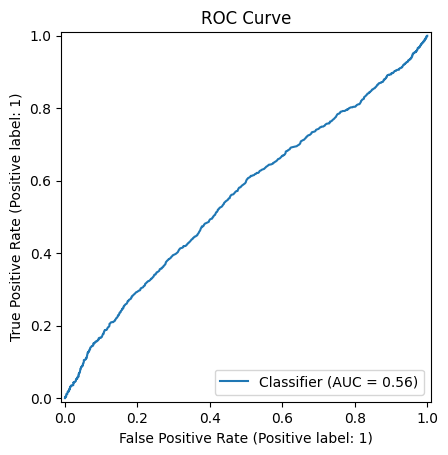

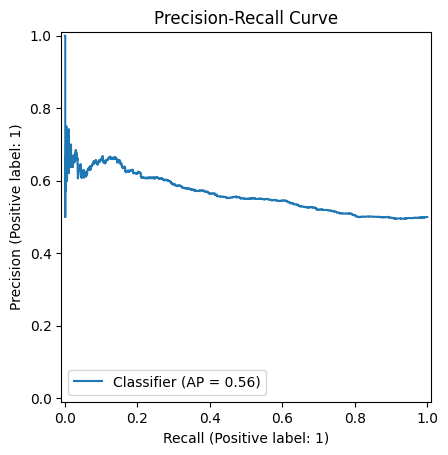


‚úÖ 'test_metrics_summary.csv' ÌååÏùºÎ°ú Ï†ÄÏû• ÏôÑÎ£å!


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

# --- ÏÑ§Ï†ï ---
CSV_PATH = "test_predictions.csv"  # CSV ÌååÏùº Í≤ΩÎ°ú

# --- 1. CSV Î∂àÎü¨Ïò§Í∏∞ ---
df = pd.read_csv(CSV_PATH)

if not {"actual_label", "final_prediction", "predicted_probability"}.issubset(df.columns):
    raise ValueError("CSV ÌååÏùºÏóê 'actual_label', 'final_prediction', 'predicted_probability' Ïª¨ÎüºÏù¥ ÌïÑÏöîÌï©ÎãàÎã§.")

y_true = df["actual_label"].astype(int)
y_pred = df["final_prediction"].astype(int)
y_prob = df["predicted_probability"].astype(float)

# --- 2. ÏÑ±Îä• ÏßÄÌëú Í≥ÑÏÇ∞ ---
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, zero_division=0),
    "Recall": recall_score(y_true, y_pred, zero_division=0),
    "F1 Score": f1_score(y_true, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_true, y_prob),
    "PR-AUC": average_precision_score(y_true, y_prob)
}

# --- 3. ÌòºÎèôÌñâÎ†¨ ---
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

# --- 4. Í≤∞Í≥º Ï∂úÎ†• ---
print("\nüìä ÏÑ±Îä• ÏßÄÌëú")
for k, v in metrics.items():
    print(f"{k:<10}: {v:.4f}")

print("\nüîç ÌòºÎèôÌñâÎ†¨")
print(cm_df)

# --- 5. ROC Curve ---
RocCurveDisplay.from_predictions(y_true, y_prob)
plt.title("ROC Curve")
plt.show()

# --- 6. Precision-Recall Curve ---
PrecisionRecallDisplay.from_predictions(y_true, y_prob)
plt.title("Precision-Recall Curve")
plt.show()

# --- 7. ÏßÄÌëúÎ•º CSVÎ°ú Ï†ÄÏû• ---
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("test_metrics_summary.csv", index=False, encoding="utf-8")
print("\n‚úÖ 'test_metrics_summary.csv' ÌååÏùºÎ°ú Ï†ÄÏû• ÏôÑÎ£å!")


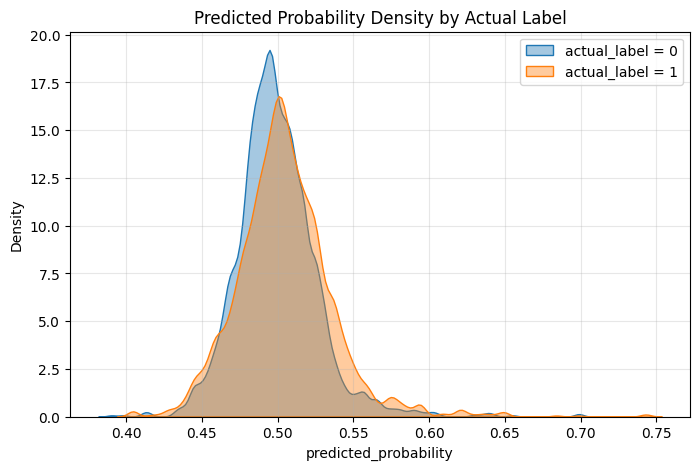

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV ÌååÏùº Î°úÎìú
df = pd.read_csv("test_predictions.csv")

plt.figure(figsize=(8, 5))

# Í∞Å Î†àÏù¥Î∏îÎ≥Ñ PDF(KDE) Í≥°ÏÑ†
for label in sorted(df['actual_label'].unique()):
    subset = df[df['actual_label'] == label]
    sns.kdeplot(
        subset['predicted_probability'],
        fill=True,       # ÏÉâÏÉÅ Ï±ÑÏö∞Í∏∞
        alpha=0.4,
        label=f"actual_label = {label}",
        bw_adjust=0.5    # Ïª§ÎÑê ÎÑàÎπÑ Ï°∞Ï†ï (Í∞í ÏûëÏúºÎ©¥ Îçî ÏÑ∏Î∞Ä)
    )

plt.xlabel("predicted_probability")
plt.ylabel("Density")
plt.title("Predicted Probability Density by Actual Label")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
